# Predicting the stock market


### Introduction

In this project, we will use data from the S&P500 index from 1950 to 2015 to predict the price for the next days. 

The dataset contains seven columns:

- Date: The date of the records
- Open: The opening price of the day (when trading starts)
- High: THe highest trade price during the day
- Low: The lowest trade price during the day
- Close: The closing price for the day (when trading is finished)
- Volume : The number of shares traded
- Adj Close: The daily closing price, adjusted retroactively to include any corporate actions.

In the project, we will first create 11 indicators (features) based on the Close, High and Low columns. Then, we will rank those features and test linear regressions models using 1 to 11 features, evaluating the error by MAE. 

After the application of the model we obtained an MAE of 12.14 and we utilized five variables: the lowest and highest price for the last day and the mean price of the last 5, 30 and 360 days.

### Reading the data

In [1]:
import pandas as pd
from datetime import datetime

df = pd.read_csv('sphist.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [2]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

Before processing the data for the machine learning algorithm, we will transform the Date columns into a datetime type and sort the dataframe by date (the data is a time series, so it doesn't make sense to use it in a different order).

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date'], ascending=True)
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


In this analysis, we will will note use the 'Adj Close' column, so we will drop it.

In [4]:
df = df.drop(columns=['Adj Close'], axis=1)

### Generating indicators

This datasets is a sequential time-series, so we cannot treat each row as independent like other machine learning projects. This means that we cannot inject "future" knowledge into past rows when training and predicting (for example, to predict an index for 2016-01-05, we can only use data prior to this date). 

So, to use as features for our model, we create a series of indicators for each row. Those indicators will be informations available at that moment (like the average price from the last 5 days, 30 days and so on). We will generate 11 indicators that can be grouped in four families:

- Average prices: The average price from the past 5, 30 and 360 days (mean_5, mean_30 and mean_360 columns) .
- Standard variation: The standard variation for the last 5, 30 and 360 days prices (std_5, std_30 and std_360 columns)
- Ration: The ration between the mean prices from the past 5 and 30 days and from the past 30 and 360 days (ration_5_360 and ration_30_360 columns).
- Last day: The high, low and volume of transactions for the last day (high_1, low_1 and volume_1).

This indicators will be generated by using the rolling function and adjusted by the shift() method (so we won't use the daily data to predict the same day).

In [5]:
# Average prices

df['mean_5'] = df['Close'].rolling(5).mean()
df['mean_5'] = df['mean_5'].shift()
df['mean_30'] = df['Close'].rolling(30).mean()
df['mean_30'] = df['mean_30'].shift()
df['mean_360'] = df['Close'].rolling(360).mean()
df['mean_360'] = df['mean_360'].shift()

# Standard variation

df['std_5'] = df['Close'].rolling(5).std()
df['std_5'] = df['std_5'].shift()
df['std_30'] = df['Close'].rolling(30).std()
df['std_30'] = df['std_30'].shift()
df['std_360'] = df['Close'].rolling(360).std()
df['std_360'] = df['std_360'].shift()

# Ratio

df['ratio_5_360'] = df['mean_5'] / df['mean_360']
df['ratio_30_360'] = df['mean_30'] / df['mean_360']

# Last day

df['high_1'] = df['High'].rolling(1).mean()
df['high_1'] = df['High'].shift()
df['low_1'] = df['Low'].rolling(1).mean()
df['low_1'] = df['Low'].shift()
df['Volume_1'] = df['Volume'].rolling(1).mean()
df['Volume_1'] = df['Volume'].shift()

In [6]:
df.head(5)

,Date,Open,High,Low,Close,Volume,mean_5,mean_30,mean_360,std_5,std_30,std_360,ratio_5_360,ratio_30_360,high_1,low_1,Volume_1
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.66,16.66,1260000.0
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.85,16.85,1890000.0
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.93,16.93,2550000.0
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.98,16.98,2010000.0


In [7]:
df.tail(5)

,Date,Open,High,Low,Close,Volume,mean_5,mean_30,mean_360,std_5,std_30,std_360,ratio_5_360,ratio_30_360,high_1,low_1,Volume_1
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2087.024023,2073.984998,2036.601862,3.916109,24.654181,64.163949,1.024758,1.018356,2093.810059,2080.409912,4.245030e+09
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2090.231982,2076.283993,2036.995389,7.956808,23.970453,64.133167,1.026135,1.019288,2103.370117,2082.929932,3.712120e+09
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2088.306006,2077.908659,2037.326723,9.333599,22.378095,64.043525,1.025023,1.019919,2104.270020,2077.110107,3.950640e+09
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2080.456006,2078.931331,2037.538667,19.599946,20.183769,63.957307,1.021063,1.020315,2085.000000,2042.349976,4.306490e+09
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2080.771973,2080.237329,2037.863862,19.806136,19.676415,63.934122,1.021055,1.020793,2093.840088,2051.239990,4.214910e+09


For same rows, there isn't data available to generate the indicators because there aren't previous data. We will solve it by removing the rows with null values from the dataset.

In [8]:
df = df.dropna(axis=0)
df.head()

,Date,Open,High,Low,Close,Volume,mean_5,mean_30,mean_360,std_5,std_30,std_360,ratio_5_360,ratio_30_360,high_1,low_1,Volume_1
16229,1951-06-12,21.520000,21.520000,21.520000,21.520000,1200000.0,21.494,21.842000,19.415056,0.105972,0.588173,1.780668,1.107079,1.125003,21.610001,21.610001,1220000.0
16228,1951-06-13,21.549999,21.549999,21.549999,21.549999,1060000.0,21.532,21.811667,19.428556,0.053573,0.580214,1.778144,1.108266,1.122660,21.520000,21.520000,1200000.0
16227,1951-06-14,21.840000,21.840000,21.840000,21.840000,1300000.0,21.546,21.779000,19.441611,0.045056,0.565785,1.776412,1.108241,1.120226,21.549999,21.549999,1060000.0
16226,1951-06-15,22.040001,22.040001,22.040001,22.040001,1370000.0,21.602,21.753000,19.455250,0.140250,0.543280,1.775924,1.110343,1.118104,21.840000,21.840000,1300000.0
16225,1951-06-18,22.049999,22.049999,22.049999,22.049999,1050000.0,21.712,21.727333,19.469306,0.222194,0.508710,1.776303,1.115191,1.115979,22.040001,22.040001,1370000.0


Now that we created the indicators, we can remove the columns used to generate them ("Open", "High", "Low" and "Volume"), keeping only the Date column, the Close column (column used as target) and the remaining indicators.

In [9]:
df = df.drop(columns=['Open', 'High', 'Low', 'Volume'], axis=1)

### Selecting features

To select the features to use in the linear regression model, we will first rank them. This rank will be done by generating a linar regression model and evaluating the MAPE using only that variable. The variables that presents a lower MAE will be ranked first.

For the error evaluation, we will divide into a training and test set. The training set will contain the data before 2013 and the test will contain the rest of the data.

In [10]:
train_df = df[df['Date']<datetime(year=2013,month=1,day=1)]
test_df = df[df['Date']>=datetime(year=2013,month=1,day=1)]

In [11]:
train_df.head()

,Date,Close,mean_5,mean_30,mean_360,std_5,std_30,std_360,ratio_5_360,ratio_30_360,high_1,low_1,Volume_1
16229,1951-06-12,21.520000,21.494,21.842000,19.415056,0.105972,0.588173,1.780668,1.107079,1.125003,21.610001,21.610001,1220000.0
16228,1951-06-13,21.549999,21.532,21.811667,19.428556,0.053573,0.580214,1.778144,1.108266,1.122660,21.520000,21.520000,1200000.0
16227,1951-06-14,21.840000,21.546,21.779000,19.441611,0.045056,0.565785,1.776412,1.108241,1.120226,21.549999,21.549999,1060000.0
16226,1951-06-15,22.040001,21.602,21.753000,19.455250,0.140250,0.543280,1.775924,1.110343,1.118104,21.840000,21.840000,1300000.0
16225,1951-06-18,22.049999,21.712,21.727333,19.469306,0.222194,0.508710,1.776303,1.115191,1.115979,22.040001,22.040001,1370000.0


In [12]:
test_df.head()

,Date,Close,mean_5,mean_30,mean_360,std_5,std_30,std_360,ratio_5_360,ratio_30_360,high_1,low_1,Volume_1
738,2013-01-02,1462.420044,1418.641992,1414.258667,1327.405278,9.820801,17.834740,91.081091,1.068733,1.065431,1426.739990,1398.109985,3.204330e+09
737,2013-01-03,1459.369995,1425.793994,1417.676668,1327.842862,22.261321,16.852563,91.350634,1.073767,1.067654,1462.430054,1426.189941,4.202600e+09
736,2013-01-04,1466.469971,1433.702002,1420.092668,1328.283695,26.274326,17.470824,91.601716,1.079364,1.069118,1465.469971,1455.530029,3.829730e+09
735,2013-01-07,1461.890015,1443.376001,1422.714665,1328.767556,27.945242,18.339803,91.870667,1.086252,1.070702,1467.939941,1458.989990,3.424290e+09
734,2013-01-08,1457.150024,1455.267993,1425.076664,1329.253528,16.453319,18.678333,92.111199,1.094801,1.072088,1466.469971,1456.619995,3.304970e+09


In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

mae_dict = {}
target = ['Close']
features = list(df.columns)
features.remove('Date')
features.remove('Close')

for feat in features:
    feat = [feat]
    lr = LinearRegression()
    lr.fit(train_df[feat], train_df[target])
    
    predictions = lr.predict(test_df[feat])
    mae = mean_absolute_error(predictions, test_df[target])
    
    mae_dict[feat[0]] = mae
    

In [14]:
mae_dict

{'mean_5': 16.26788202972279,
 'mean_30': 31.970389013374486,
 'mean_360': 144.66761007668362,
 'std_5': 1005.6461568449685,
 'std_30': 898.9283309744163,
 'std_360': 768.9599725984693,
 'ratio_5_360': 1448.09895111601,
 'ratio_30_360': 1448.0676436357137,
 'high_1': 14.111753830080781,
 'low_1': 13.012598631432907,
 'Volume_1': 748.9931180039952}

In [15]:
variables_df = pd.DataFrame.from_dict(mae_dict, orient='index')
variables_df['MAE'] = variables_df[0]
variables_df = variables_df.drop(0, axis=1)
sorted_df = variables_df['MAE'].sort_values()
sorted_df

low_1             13.012599
high_1            14.111754
mean_5            16.267882
mean_30           31.970389
mean_360         144.667610
Volume_1         748.993118
std_360          768.959973
std_30           898.928331
std_5           1005.646157
ratio_30_360    1448.067644
ratio_5_360     1448.098951
Name: MAE, dtype: float64

### Predicting and evaluation model error

In the last step, we ranked the 11 indicators by the MAE. Now, we will predict the final prices using from 1 to 11 variables, using the order of the last step. We will used the same train and test set as the last step.

In [16]:
from sklearn.model_selection import cross_val_score, KFold

features_list = list(sorted_df.index)
mae_list = []

for i in range(1, len(features_list)+1):
    features = features_list[:i]
    
    lr = LinearRegression()
    lr.fit(train_df[features], train_df[target])
    
    predictions = lr.predict(test_df[features])
    mae = mean_absolute_error(predictions, test_df[target])
    
    mae_list.append(mae)

for i in range(0, 11):
    print(str(i + 1)+": "+str(mae_list[i]))

1: 13.012598631432907
2: 12.212704636343856
3: 12.179672430724354
4: 12.16977699602196
5: 12.14567431738302
6: 12.145941762873491
7: 12.168473941140268
8: 12.170973087061135
9: 12.171264992496333
10: 12.166961774930224
11: 12.16689822114124


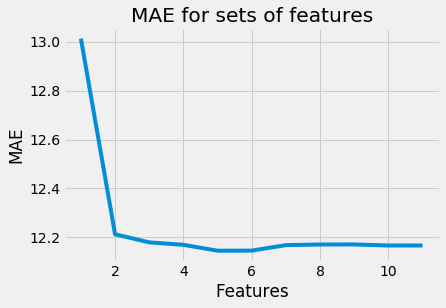

In [18]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

y = mae_list
x = [i for i in range(1, len(mae_list) + 1)]
plt.title("MAE for sets of features")
plt.xlabel('Features')
plt.ylabel("MAE")
plt.plot(x,y)

plt.show()

From the graph, we can see there is a big decrease in error in selecting 2 instead of 1 variable, but after this point the error change slowly. The small error is achieved with five variables (low_1, high_1, mean_5, mean_30 and mean_360) and has a value of 12.14.